# Pytorch Capstone Project - Image Classification for detection of Diabetic Retinopathy
This project involves building and training a Convolutional Neural Network model using Pytorch to detect Diabetic retinopathy based on images of retinas. The dataset used is from Indian Diabetic Retinopathy Image Dataset (IDRiD), which consists of 516 fundus images. This dataset is split into 413 training images and 103 testing images.

The goal is to train the model to detect whether the image is indicative of diabetic retinopathy. Hence, this is a binary classification model, so it will make use of Pytorch's Binary Cross Entropy loss function to calculate weights. It also uses the Adam optimizer, with a learning rate of 0.0002.

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print(f'Available device: {device}')

Available device: cpu


In [4]:
training_csv_path = 'B. Disease Grading/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
testing_csv_path = 'B. Disease Grading/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'
root_disease_grading_path = 'B. Disease Grading/B. Disease Grading/'

training_images_path = 'B. Disease Grading/B. Disease Grading/1. Original Images/a. Training Set/'
testing_images_path = 'B. Disease Grading/B. Disease Grading/1. Original Images/b. Testing Set/'

In [5]:
class RetinalImageDataset(Dataset):
    def __init__(self, csv_df, images_path, transform=None, num_samples=None):
        """
        Args:
            csv_df (string): Dataframe from the csv file containing the data set
            transform (callable, optional): Optional transform to be applied on a sample
            num_samples (int, optional): Number of samples to load. If None, loads all samples
            images_path (string): Path to image set
        """
        self.csv_file = csv_df
        if num_samples is not None:
            self.csv_file = self.csv_file.head(num_samples)
        self.transform = transform
        self.images_path = images_path

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        # Get image path and label
        img_path = self.images_path + self.csv_file.iloc[index, 0] + '.jpg'
        label = self.csv_file.iloc[index, 1]
        #print(f'Path: {img_path}, Label: {label}')

        # Load and convert the image
        image = Image.open(img_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Convert label to float
        label = torch.tensor(label, dtype=torch.float)

        return image, label

In [6]:
# Data Cleaning
training_csvfile = pd.read_csv(training_csv_path)
unnamed_columns = training_csvfile.columns[training_csvfile.columns.str.contains('Unnamed', case=False)]
training_csvfile = training_csvfile.drop(columns=unnamed_columns)

drop_columns = ['Retinopathy grade', 'Risk of macular edema ']

training_csvfile['Has Retinopathy'] = (training_csvfile['Retinopathy grade'] > 0).astype(int)
training_csvfile = training_csvfile.drop(columns=drop_columns)

testing_csvfile = pd.read_csv(testing_csv_path)
testing_csvfile['Has Retinopathy'] = (testing_csvfile['Retinopathy grade'] > 0).astype(int)
testing_csvfile = testing_csvfile.drop(columns=drop_columns)

print('Training\n', training_csvfile[185:195])
print('\nTesting\n',testing_csvfile[35:45])

Training
     Image name  Has Retinopathy
185  IDRiD_186                1
186  IDRiD_187                1
187  IDRiD_188                1
188  IDRiD_189                1
189  IDRiD_190                0
190  IDRiD_191                1
191  IDRiD_192                1
192  IDRiD_193                0
193  IDRiD_194                1
194  IDRiD_195                0

Testing
    Image name  Has Retinopathy
35  IDRiD_036                1
36  IDRiD_037                0
37  IDRiD_038                0
38  IDRiD_039                0
39  IDRiD_040                1
40  IDRiD_041                0
41  IDRiD_042                1
42  IDRiD_043                0
43  IDRiD_044                0
44  IDRiD_045                0


## Image Pre-processing and Augmentation
The raw images will undergo pre-processing to ensure that the images are in a standardized format. This involves resizing them to a standard size, converting to PyTorch tensors, and normalizing the pixel values. All the images are resized to be 256x256.

The raw images from the training set will additionally go through various random augmentations to provide variance within the images and allow the model to train with more diverse data. This should help prevent overfitting and improve generalization. The augmentations include randomly flipping the image horizontally and vertically, randomly rotating the image, adjusting various colour parameters like brightness, contrast, saturation, and hue, and finally, randomly changing the perspective of the image.

In [7]:
# Image Pre-Processing
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomPerspective(0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])   
])

val_and_testing_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])   
])

## Splitting dataset into training and validation set
The dataset is split into a training set and validation set in order to track the performance of the model. It is split such that 80% of the images are part of the training set, and 20% is a part of the validation set. This makes 331 images to train and 82 for validation.

The image augmentations mentioned are done specifically to the training images, not the validation images.

In [8]:
# Load dataset
retinal_image_dataset = RetinalImageDataset(training_csvfile, training_images_path, transform=train_transforms)
train_size = 0.8
val_size = 0.2

train_dataset, _ = random_split(retinal_image_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

retinal_image_dataset2 = RetinalImageDataset(training_csvfile, training_images_path, transform=val_and_testing_transforms)
train_size = 0.8
val_size = 0.2

_, val_dataset = random_split(retinal_image_dataset2, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(train_dataset.indices)
print(val_dataset.indices)
print(f'Size of training indices list: {len(train_dataset.indices)}')
print(f'Size of val indices list: {len(val_dataset.indices)}')
print(f'Common elements: {list(set(train_dataset.indices) & set(val_dataset.indices))}')
            

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(f'Loading image from path: {training_images_path}')
print(f'Size of training set: {len(train_dataset)}')
print(f'Size of validation set: {len(val_dataset)}')

[64, 20, 234, 257, 282, 28, 196, 411, 183, 342, 261, 363, 310, 167, 50, 335, 122, 372, 135, 71, 96, 105, 4, 154, 141, 182, 73, 106, 240, 216, 302, 407, 24, 30, 339, 357, 296, 101, 45, 367, 278, 155, 397, 412, 92, 36, 56, 237, 391, 54, 272, 1, 100, 152, 85, 25, 153, 389, 136, 41, 148, 195, 406, 173, 32, 23, 322, 93, 264, 346, 109, 224, 81, 366, 360, 300, 14, 408, 126, 51, 33, 188, 376, 236, 354, 151, 192, 191, 393, 306, 158, 242, 356, 22, 231, 82, 169, 332, 319, 323, 204, 254, 142, 248, 9, 118, 210, 198, 338, 123, 97, 387, 405, 134, 111, 348, 253, 362, 57, 395, 286, 165, 127, 98, 328, 308, 355, 235, 13, 244, 214, 295, 341, 233, 159, 133, 379, 285, 107, 58, 181, 381, 119, 262, 287, 203, 340, 303, 276, 396, 258, 271, 368, 291, 139, 77, 114, 62, 293, 43, 345, 241, 207, 74, 222, 197, 263, 229, 410, 27, 171, 385, 277, 184, 175, 69, 382, 156, 301, 160, 53, 7, 117, 213, 337, 309, 40, 299, 384, 202, 162, 313, 369, 223, 140, 220, 290, 304, 209, 305, 267, 260, 365, 48, 294, 297, 76, 37, 55, 161, 

## Convolutional Neural Network architecture
This neural network consists of three convolutional layers consisting of a 3x3 kernel with padding. A 2x2 max-pooling kernel is used after each convolution layer to reduce the dimentionality while retaining important information. The output of the last max-pooling layer is sent to two fully connected layers. Each of the layers uses the ReLU activation function, except the final layer, which uses sigmoid function.

In [8]:
# Convolutional Neural Network architecture

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(128 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)).squeeze(1)
        return x

cnn_model = CNN()
cnn_model = cnn_model.to(device)

## Training the model
The model uses the Binary Cross Entropy loss function and the Adam optimizer, with a learning rate of 0.0002. The training and validation loop runs for five epochs, and the training and validation losses are tracked and graphed visually to see how it performs over all the epochs.

In [9]:
# Initialize loss function and optimizers
criterion = nn.BCELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0002)

In [10]:
# Training and Validation Loop
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0

    # Training
    cnn_model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_losses.append(total_train_loss / len(train_dataloader))

    # Validation
    cnn_model.eval()
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            val_outputs = cnn_model(images)
            val_loss = criterion(val_outputs, labels)
            total_val_loss += val_loss.item()
        val_losses.append(total_val_loss / len(val_dataloader))
    
    # Print Epochs and loss information
    print(f'Epoch: [{epoch + 1}/{num_epochs}], Training Loss: {total_train_loss / len(train_dataloader)} , Validation Loss: {total_val_loss / len(val_dataloader)}')


Epoch: [1/5], Training Loss: 0.6474530127915469 , Validation Loss: 0.575467179218928
Epoch: [2/5], Training Loss: 0.6222896115346388 , Validation Loss: 0.5615423818429311
Epoch: [3/5], Training Loss: 0.611074068329551 , Validation Loss: 0.5671188632647196
Epoch: [4/5], Training Loss: 0.5786502063274384 , Validation Loss: 0.5407244066397349
Epoch: [5/5], Training Loss: 0.6045887090943076 , Validation Loss: 0.5248966614405314


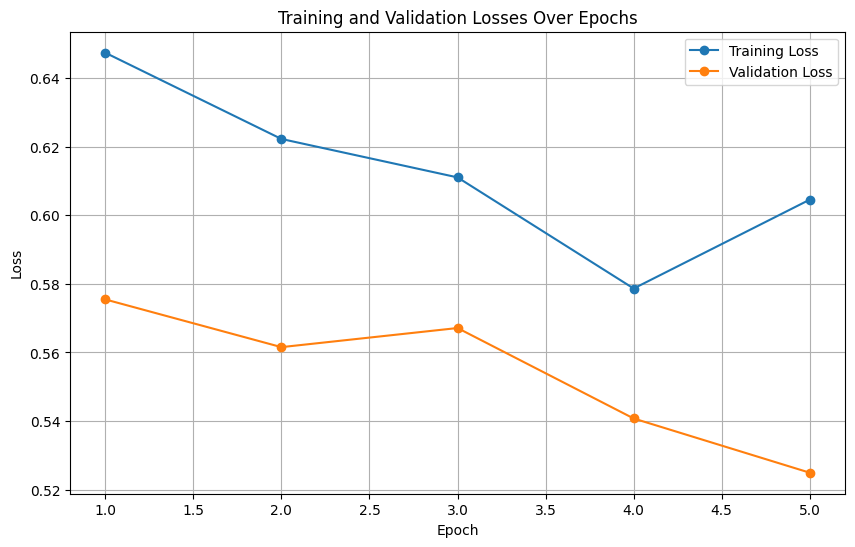

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Testing the model
# Load the testing data set

test_dataset = RetinalImageDataset(testing_csvfile, testing_images_path, transform=val_and_testing_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [13]:
test_pred_probs = []
test_pred_labels = []
test_true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)

        test_pred_probs.extend(outputs.cpu().numpy())

        pred_labels = torch.round(outputs)
        test_pred_labels.extend(pred_labels.cpu().numpy())

        test_true_labels.extend(labels.cpu().numpy())

test_pred_probs = np.array(test_pred_probs)
test_pred_labels = np.array(test_pred_labels)
test_true_labels = np.array(test_true_labels)

for i in range(103):
    print(f'Predicted Probablity:{test_pred_probs[i]}, Predicted Label:{test_pred_labels[i]}, Actual Label:{test_true_labels[i]}')

Predicted Probablity:0.4694424569606781, Predicted Label:0.0, Actual Label:1.0
Predicted Probablity:0.7268581986427307, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.8200249671936035, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6288398504257202, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.48248523473739624, Predicted Label:0.0, Actual Label:1.0
Predicted Probablity:0.7302005290985107, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.8633617758750916, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.8178542852401733, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.8525545597076416, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6357084512710571, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6245272755622864, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.8588058948516846, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.8832235336303711, Predicted 

In [14]:
from sklearn.metrics import classification_report

classes = ['Does not have retinopathy', 'Has retinopathy']

report = classification_report(test_true_labels, test_pred_labels, target_names=classes)

print(report)

                           precision    recall  f1-score   support

Does not have retinopathy       0.50      0.06      0.11        34
          Has retinopathy       0.68      0.97      0.80        69

                 accuracy                           0.67       103
                macro avg       0.59      0.51      0.45       103
             weighted avg       0.62      0.67      0.57       103



## Results
We see that based on our CNN model, the model has an accuracy score of 59%. The model performs quite well when it comes to detecting if an image indicates it has retinopathy. However, it struggles to accurately detect images that indicates it did not have retinopathy. Some ways to combat this may be to use a much larger dataset, preprocessing the data further to improve variance and remove noise, or modifying the model with different number of hidden layers and neurons. 

## VGG-16 Convolutional Neural Network Model
VGG-16 is a Convolutional Neural Network Model that is proposed by Karen Simonyan and Andrew Zisserman from the Visual Geometry Group at University of Oxford. It is designed for training large scale models for image classification tasks. While it is best used for larger datasets, I wanted to try to implement it to see how it performs with this IDRiD dataset.

## VGG-16 Architecture and implementation
VGG-16 consists of a total of 16 layers, of which there are 13 convolutional layers, and 3 fully connected layers. The convolutional layers have a kernel size of 3x3 and a padding of 1. There are 2 sets of convolutional layers having 64 output channels, 2 sets with 128 output channels, 3 sets with 256 output channels, and 6 sets with 512 output channels. 

There are also 5 max-pooling layers with a kernel size of 2x2, and a stride of 2. Each of these pooling layers come after each of the sets, and one of them in the middle of the sets with 512 output channels.

The output of the final pooling layer is flattened and sent to three fully connected linear layers. Two of them have an output size of 4096. For this specific binary classification task, the final layer has an output of 1.

All of these channels are given the ReLU activation function, except the last one, which uses the sigmoid function.

In [22]:
# Training with a CNN model based on VGG-16

class VGG_16_CNN(nn.Module):
    def __init__(self):
        super(VGG_16_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)

        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(512)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn10 = nn.BatchNorm2d(512)
        
        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(512)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(512)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn13 = nn.BatchNorm2d(512)
        
        self.fc1 = nn.Linear(512 * 8 * 8, 4096)
        self.bn_fc1 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn_fc2 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn11(self.conv11(x)))
        x = F.relu(self.bn12(self.conv12(x)))
        x = F.relu(self.bn13(self.conv13(x)))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x)).squeeze(1)
        return x

vgg_16_cnn_model = VGG_16_CNN()
vgg_16_cnn_model = vgg_16_cnn_model.to(device)

In [ ]:
# Initialize loss function and optimizers
criterion = nn.BCELoss()
optimizer = optim.Adam(vgg_16_cnn_model.parameters(), lr=0.0025, weight_decay=1e-4)


3


In [24]:
# Training and Validation Loop
num_epochs = 6
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0

    # Training
    vgg_16_cnn_model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg_16_cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_losses.append(total_train_loss / len(train_dataloader))

    # Validation
    vgg_16_cnn_model.eval()
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            val_outputs = vgg_16_cnn_model(images)
            val_loss = criterion(val_outputs, labels)
            total_val_loss += val_loss.item()
        val_losses.append(total_val_loss / len(val_dataloader))
    
    # Print Epochs and loss information
    print(f'Epoch: [{epoch + 1}/{num_epochs}], Training Loss: {total_train_loss / len(train_dataloader)} , Validation Loss: {total_val_loss / len(val_dataloader)}')


Epoch: [1/6], Training Loss: 5.446965277194977 , Validation Loss: 28.472222010294598
Epoch: [2/6], Training Loss: 2.965788169340654 , Validation Loss: 28.472222010294598
Epoch: [3/6], Training Loss: 2.6577278646555813 , Validation Loss: 2.733336846033732
Epoch: [4/6], Training Loss: 1.4967479380694302 , Validation Loss: 0.6114498376846313
Epoch: [5/6], Training Loss: 0.9052477370608937 , Validation Loss: 0.6001193324724833
Epoch: [6/6], Training Loss: 1.53104229406877 , Validation Loss: 0.6000682314236959


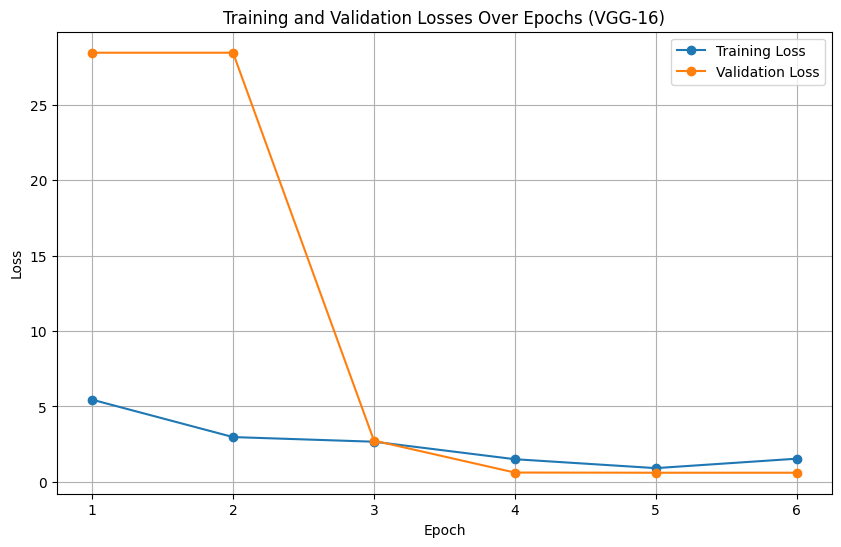

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs (VGG-16)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Testing the model
# Load the testing data set

test_dataset = RetinalImageDataset(testing_csvfile, testing_images_path, transform=val_and_testing_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [27]:
test_pred_probs = []
test_pred_labels = []
test_true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_16_cnn_model(images)

        test_pred_probs.extend(outputs.cpu().numpy())

        pred_labels = torch.round(outputs)
        test_pred_labels.extend(pred_labels.cpu().numpy())

        test_true_labels.extend(labels.cpu().numpy())

test_pred_probs = np.array(test_pred_probs)
test_pred_labels = np.array(test_pred_labels)
test_true_labels = np.array(test_true_labels)

for i in range(103):
    print(f'Predicted Probablity:{test_pred_probs[i]}, Predicted Label:{test_pred_labels[i]}, Actual Label:{test_true_labels[i]}')

Predicted Probablity:0.6778742671012878, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6786175966262817, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6788851618766785, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6764877438545227, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6765541434288025, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.677167534828186, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6783359050750732, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6761113405227661, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6787475347518921, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6764748692512512, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6786090135574341, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.6771881580352783, Predicted Label:1.0, Actual Label:1.0
Predicted Probablity:0.677900493144989, Predicted Lab

In [28]:
from sklearn.metrics import classification_report

classes = ['Does not have retinopathy', 'Has retinopathy']

report = classification_report(test_true_labels, test_pred_labels, target_names=classes)

print(report)

                           precision    recall  f1-score   support

Does not have retinopathy       0.00      0.00      0.00        34
          Has retinopathy       0.67      1.00      0.80        69

                 accuracy                           0.67       103
                macro avg       0.33      0.50      0.40       103
             weighted avg       0.45      0.67      0.54       103



d:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Results
This model has an accuracy score of 66%. It is good at detecting retinas without retinopathy. It tended to rate pretty much all images as having retinopathy, as the predicted output values were higher than 0.5. Overall, the accuracy is not much better than the accuracy from the first CNN model, indicating that adding more hidden layers did not improve the accuracy. Such complex models can suffer from the Vanishing Gradient problem, which is why a Batch Normalization layer is applied after every layer. Other ways to improve the model include using a scheduler to lower the learning rate during the training process, and also utilizing a larger dataset so that the model could train better. 

# Conclusion

Overall, both the regular CNN model and the VGG-16 based model performed somewhat similarly. Despite the VGG-16 model being quite complex, it did not perform much better. It also took a much longer time to train than the original model. The original model took about 5 to 6 minutes to train for 5 epochs, while the VGG-16 model took more than 10 minutes to train for 3 epochs. Perhaps the model could improve if it ran for more epochs, but this would take a long time. Furthermore, reducing the complexity can help the model to not overfit and improve the outputs.

All in all, though these two models were able to detect whether some of the image indicated retinopathy, they would not be ideal for an actual doctor to diagnose retinopathy. Given this dataset, a fine-tuned, pre-trained model like a vision transformer, that has been trained on a much larger dataset, might be best suited to analyze retinal images for diabetic retinopathy. 